# Clustering songs
In this notebook we compare performance of different clustering algorithms - Kmeans clustering, hierarchical clustering, LDA clustering and semi-supervised learning with label propagation - on a subset of original *55000+ Song Lyrics* dataset.  
In addition we show how to use silhouette score to automatically choose the number of clusters and we label clusters with words.

## Acknowledgments
Libraries' documentations, many solutions that I found on Stackoverflow.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import string
import collections

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

import sklearn
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import scipy as sc
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import ward, dendrogram

import gensim
from gensim import corpora
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

from itertools import chain

import json

%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data

### Reading the data

In [3]:
df = pd.read_csv('songdata.csv')
# remove new lines from lyrics
df['text'] = df.text.apply(lambda x: x.replace('\n',''))

### Choosing the artists whose songs we cluster
For the sake of simplicity we choose artists from different music genres on purpose.

In [4]:
artists = ['Death', 'Xzibit', 'Britney Spears']
num_artists = len(artists)
df_artists = df.loc[df.artist.isin(artists)]
for artist in artists:
    print ('Number of {} songs: {}'.format(artist, len(df_artists[df_artists.artist == artist])))

Number of Death songs: 60
Number of Xzibit songs: 47
Number of Britney Spears songs: 158


In [5]:
df_artists.head()

,artist,song,link,text
1951,Britney Spears,3,/b/britney+spears/3_20853253.html,"One, two, three Not only you and me Got one ..."
1952,Britney Spears,Am I A Sinner,/b/britney+spears/am+i+a+sinner_20897704.html,Keep telling myself Get out of my mind The w...
1953,Britney Spears,Anticipating,/b/britney+spears/anticipating_20024618.html,"Top down on the strip, looking in the mirror ..."
1954,Britney Spears,Autumn Goodbye,/b/britney+spears/autumn+goodbye_20024645.html,[Chorus] I never promised you a happy ending ...
1955,Britney Spears,Better,/b/britney+spears/better_21110781.html,[Verse 1] Let's undo all the distance From y...


## Preprocessing 

We need to define how we preprocess the lyrics of a song.  
We use the following pipeline:

1. Remove punctuation.
2. Lower text.
3. Tokenize.
4. Remove stop words.
5. Stem.

*NLTK stopwords.words('english')* contains only lowercase letters and we don't want any punctuation in the tokens so we remove punctuation and lower text before the tokenization. After we can remove stop words and proceed with stemming or lemmatization if we want to.

In [6]:
stopwords = stopwords.words('english')
punctuation = string.punctuation
trantab = str.maketrans(punctuation, ' '*len(punctuation))

def process_text(text):
    """Remove punctuation, lower text, tokenize text, remove stop words and stem tokens (words).
    Args:
      text: a string.
    Returns:
      Tokenized text i.e. list of stemmed words. 
    """
    
    # replace all punctuation by blanc spaces
    text = text.translate(trantab)
    
    # lower text
    text = text.lower()
    
    # tokenize text
    word_tokens = word_tokenize(text) 
  
    # remove stop words
    filtered_text = [w for w in word_tokens if not w in stopwords] 
        
    # stemm text
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in filtered_text]

    return tokens

## Transforming text to numerical features (td-idf)
We separate the computation of *tf-idf* matrix into 2 steps (*define_vectorizer()* and *compute_tfidf_matrix()*) because later we will need the *vectorizer* itself (for auto-labelling of clusters).

In [7]:
def define_vectorizer(additional_stopwords = [], max_df=0.5, min_df=0.1, ngram_range=(1, 1)):
    """Transform texts to Tf-Idf coordinates.
    Args:
      additional_stop_words: addititional stop_words, list of strings.
      ngram_range: tuple (min_n, max_n) (default=(1, 1))
        The lower and upper boundary of the range of n-values for different n-grams to be extracted.
        All values of n such that min_n <= n <= max_n will be used.
      max_df: float in range [0.0, 1.0] or int
        When building the vocabulary ignore terms that have a document frequency strictly higher than
        the given threshold (corpus-specific stop words).
        If float, the parameter represents a proportion of documents, integer absolute counts.
        This parameter is ignored if vocabulary is not None.
      min_df: float in range [0.0, 1.0] or int
        When building the vocabulary ignore terms that have a document frequency strictly lower than
        the given threshold. This value is also called cut-off in the literature.
        If float, the parameter represents a proportion of documents, integer absolute counts.
        This parameter is ignored if vocabulary is not None.
    Returns:
      Vectorizer. 
    """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                             stop_words=additional_stopwords,
                             max_df=max_df,
                             min_df=min_df,
                             ngram_range=ngram_range)
    return vectorizer

def compute_tfidf_matrix(corpus, vectorizer):
    """Transform texts to Tf-Idf coordinates.
    Args:
      corpus: list of strings.
      vectorizer: sklearn TfidfVectorizer.
    Returns:
      A sparse matrix in Compressed Sparse Row format with tf-idf scores.
    Raises:
      ValueError: If `corpus` generates empty vocabulary or after pruning no terms remain.
    """
    tfidf_matrix = vectorizer.fit_transform(corpus) # raises ValueError if bad corpus
    return tfidf_matrix

def corpus_features(df, field):
    """
    Returns vectorizer, tfidf_matrix, dist computed on df[field].
    """
    corpus = df[field].values
    vectorizer = define_vectorizer()
    tfidf_matrix = compute_tfidf_matrix(corpus = corpus, vectorizer = vectorizer)
    dist = 1 - cosine_similarity(tfidf_matrix)
    return vectorizer, tfidf_matrix, dist

Choose the field on which we want to cluster. For instance it could be *song* (name of the songs) or *text* (lyrics of the songs).

In [8]:
field = 'text'

Once we have chosen the field on which we want to cluster, we define *corpus, vectorizer, tfidf_matrix* here
and will pass them to clustering functions in order to save computational time.

In [9]:
vectorizer, tfidf_matrix, dist = corpus_features(df_artists, field)

And now we need to define the number of clusters that we want to have.
At first we set *num_clusters = num_artists* which is cheating because we know that we want to have *num_artists* clusters, but later we will try some methods in order to automatically find the optimal number of clusters.

In [10]:
num_clusters = num_artists

## Clustering

### Util functions

In [11]:
def annotate_labels(labels, vectorizer, tfidf_matrix, num_clusters, num_words = 3):
    """ Label clusters with num_words most common words """
    feature_array = vectorizer.get_feature_names()
    # we create a numpy array here in order to use list indexing list_of_clusters[cluster_texts_index]
    # we choose dtype=object because str type will actually be char (string of length 1)
    list_of_clusters = np.empty(len(labels), dtype=object)
    for i in range(num_clusters):
        cluster_texts_index = np.where(labels==i)[0]
        r = tfidf_matrix[cluster_texts_index]
        tfidf_sorting = np.argsort(r.toarray()).flatten()[::-1]
        top_n = [feature_array[k] for k in tfidf_sorting][:num_words]
        word_label = ' '.join(top_n)
        list_of_clusters[cluster_texts_index] = str(i)+' '+word_label # total_label #str(i)+'
    return list_of_clusters
    
def dict_labels(labels): 
    """ Returns a dictionary with names of clusters as keys and lists of indices of corresponding elements as values """
    clustering = collections.defaultdict(list)
    for i, label in enumerate(labels):
        clustering[label].append(i) 
    return dict(clustering)

def conf_matrix_clusters(df, clusters):
    """ Prints the confusion matrix """
    results = []
    cluster_names = clusters.keys()
    assert df['artist'].nunique() == len(cluster_names), "conf_matrix_clusters() only works for num_clusters == num_artists"
    for k in cluster_names:
        row = df.iloc[clusters[k]].groupby('artist')['song'].nunique().to_dict()
        for artist in artists:
            if artist not in row:
                row[artist] = 0
        results.append(row)
    
    results_df = pd.DataFrame(results, cluster_names).transpose()
    
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(results_df, annot=True, fmt="d", cmap="YlGnBu", ax=ax)

### K-Means clustering

In [12]:
def kmeans_clustering(vectorizer, tfidf_matrix, num_clusters = 0):
    """Perform KMeans clustering.
    Args:
      vectorizer: vectorizer.
      tfidf_matrix: tfidf_matrix.
      num_clusters: non-negative integer. If 0, automatically chooses the optimal number of clusters using
        silouhettes, otherwise performs clustering with `num_clusters` clusters.
    Returns:
      List `labels` where `labels[i]` is the cluster of `i`-th string in the `corpus`.
    """
    
    feature_array = vectorizer.get_feature_names()
    labels = []
    
    # custom number of clusters
    if num_clusters != 0:  
        # fix random_state for reproducibility
        km_model = KMeans(n_clusters=num_clusters, random_state = 42).fit(tfidf_matrix)
        labels = km_model.labels_
        #clusters = cluster_texts(km_model) 
    # auto - using the maximal silhouette score
    if num_clusters == 0:
        range_n_clusters = range(2,21)
        silhouettes = []
        for n_clusters in range_n_clusters:
            km_model = KMeans(n_clusters=n_clusters).fit(tfidf_matrix)
            labels = km_model.labels_
            silhouettes.append(silhouette_score(tfidf_matrix, labels))
        num_clusters = np.argmax(silhouettes) + range_n_clusters[0]
        km_model = KMeans(n_clusters=num_clusters).fit(tfidf_matrix)
        labels = km_model.labels_
        
    return labels

### Hierarchical clustering

In [13]:
def hierarchical_clustering(vectorizer, tfidf_matrix, num_clusters = 0):
    """Perform hierarchical clustering.
    Args:
      vectorizer: vectorizer.
      tfidf_matrix: tfidf_matrix.
      num_clusters: non-negative integer. If 0, automatically chooses the optimal number of clusters using
        silouhettes, otherwise performs clustering with `num_clusters` clusters.
    Returns:
      List `labels` where `labels[i]` is the cluster of `i`-th string in the `corpus`.
    """
    feature_array = vectorizer.get_feature_names()
    labels = []
    
    # for hierarchical clustering
    dist = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist)
        
    # custom number of clusters
    if num_clusters != 0:  
        labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust') - 1 # substract 1 to get numeration from 0
    # auto - using the maximal silhouette score
    if num_clusters == 0:
        range_n_clusters = range(2,21)
        silhouettes = []
        for n_clusters in range_n_clusters:
            labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1 # substract 1 to get numeration from 0
            silhouettes.append(silhouette_score(tfidf_matrix, labels))
        num_clusters = np.argmax(silhouettes) + range_n_clusters[0]
        labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust') - 1 # substract 1 to get numeration from 0
    
    return labels

### Define a compact function for clustering

In [14]:
def cluster(clustering_function, vectorizer, tfidf_matrix, num_clusters = 3):
    labels = clustering_function( vectorizer, tfidf_matrix, num_clusters)
    annotated_labels = annotate_labels(labels, vectorizer, tfidf_matrix, num_clusters, num_words = 3)
    dict_cluster_indices = dict_labels(annotated_labels)
    conf_matrix_clusters(df_artists, dict_cluster_indices)
    return annotated_labels

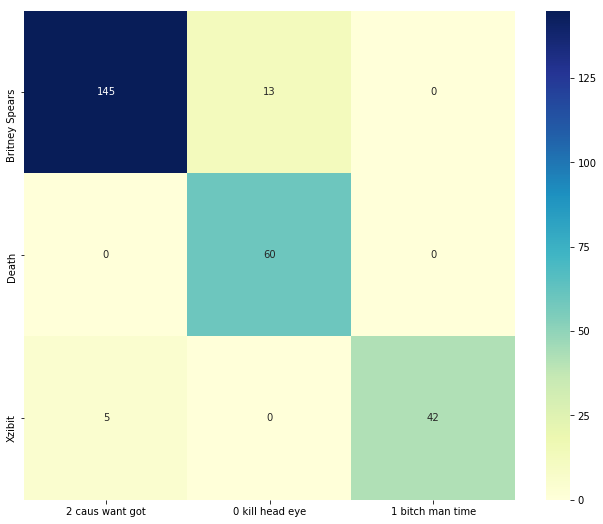

In [15]:
kmeans_labels = cluster(kmeans_clustering, vectorizer, tfidf_matrix, num_clusters = 3)

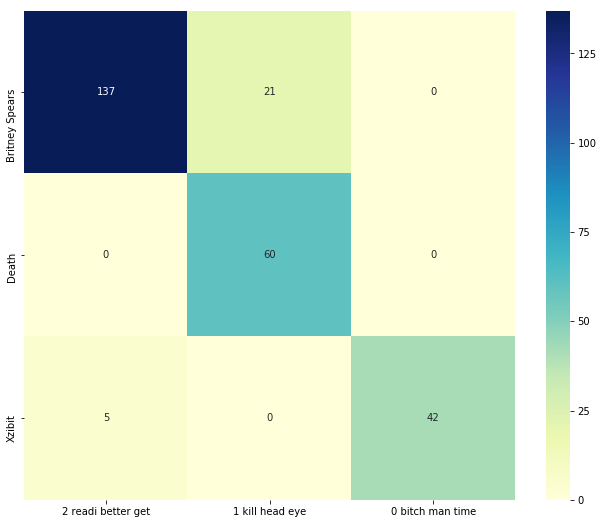

In [16]:
hierarchical_labels = cluster(hierarchical_clustering, vectorizer, tfidf_matrix, num_clusters = 3)

Note that the cluster names are different - this is so because the cluster names are defined by the songs in the clusters and the produced sets of songs in the clusters are different for KMeans and Hierarchical clusterings.

### Vizualization

In [17]:
def viz_clusters(dist, labels):
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]   
    
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df_viz = pd.DataFrame(dict(x=xs, y=ys, label=labels, title=df_artists['song'].values)) 
    #group by cluster
    groups = df_viz.groupby('label')


    # set up plot
    fig, ax = plt.subplots(figsize=(21, 15)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    # note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        label = group.iloc[0]['label']
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=label, mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, top=False, labelleft=False)

    ax.legend(numpoints=1)  # show legend with only 1 point

    # add label in x,y position with the label as the film title
    for i in range(len(df_viz)):
        ax.text(df_viz.iloc[i]['x'], df_viz.iloc[i]['y'], df_viz.iloc[i]['title'], size=8)  

    plt.show() #show the plot
    
def plot_dendrogram(vectorizer, dist):
    """Plots a dendogram which shows how hierarchical clustering works.
    Args:
      df: pandas data frame with the column `cluster`.
      field: a column in `df` on which we will perform clustering.
    Returns:
      Nothing. Plots the dendogram.
    Raises:
      AssertionError: If a parameter is wrong.
    """
    
    linkage_matrix = ward(dist)

    fig, ax = plt.subplots(figsize=(15, 30)) # set size
    ax = dendrogram(linkage_matrix, orientation="right");

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    plt.tight_layout()

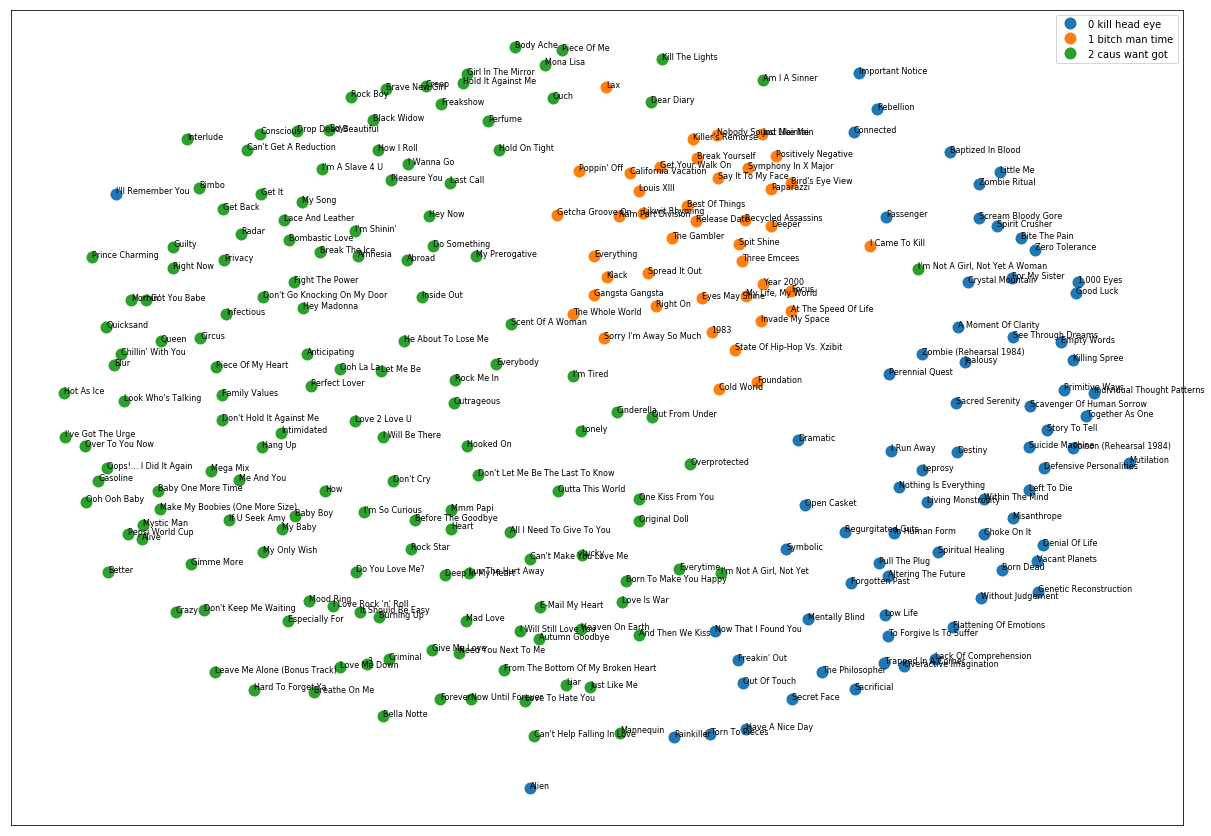

In [18]:
viz_clusters(dist, kmeans_labels)

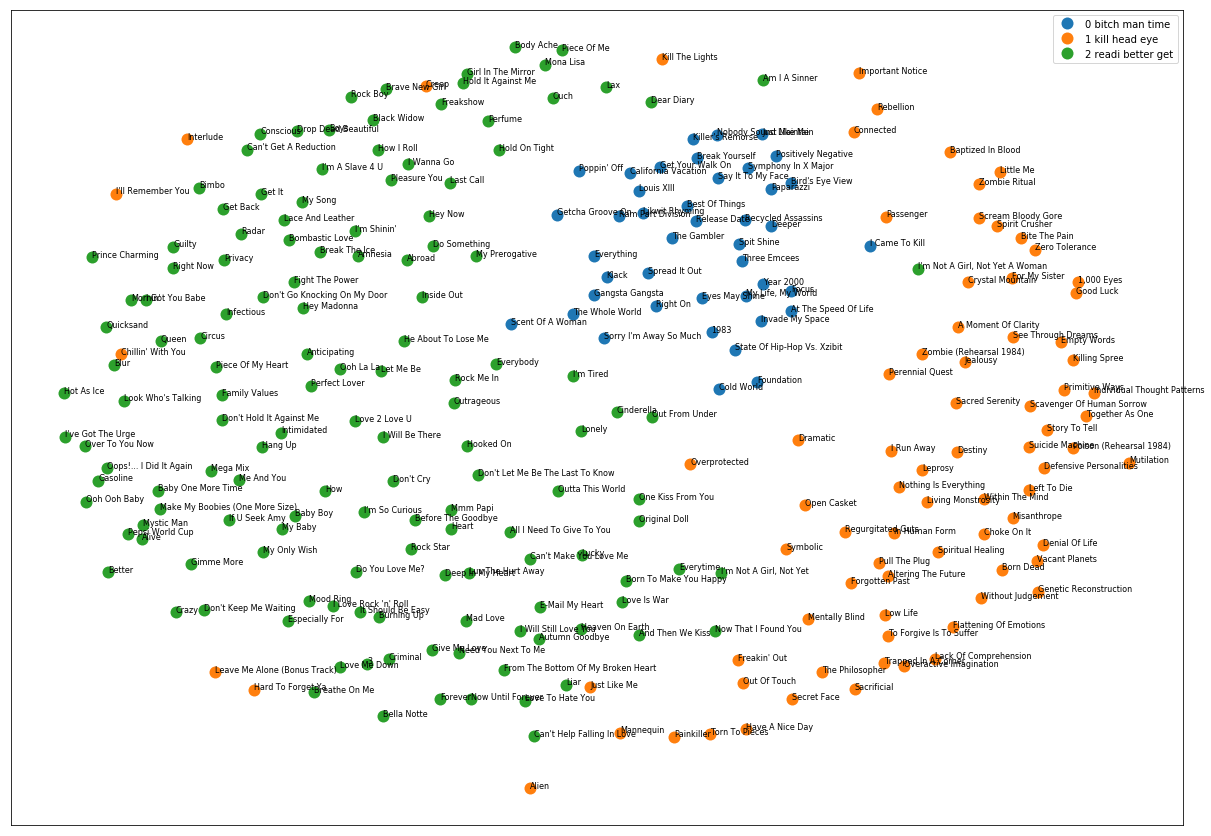

In [19]:
viz_clusters(dist, hierarchical_labels)

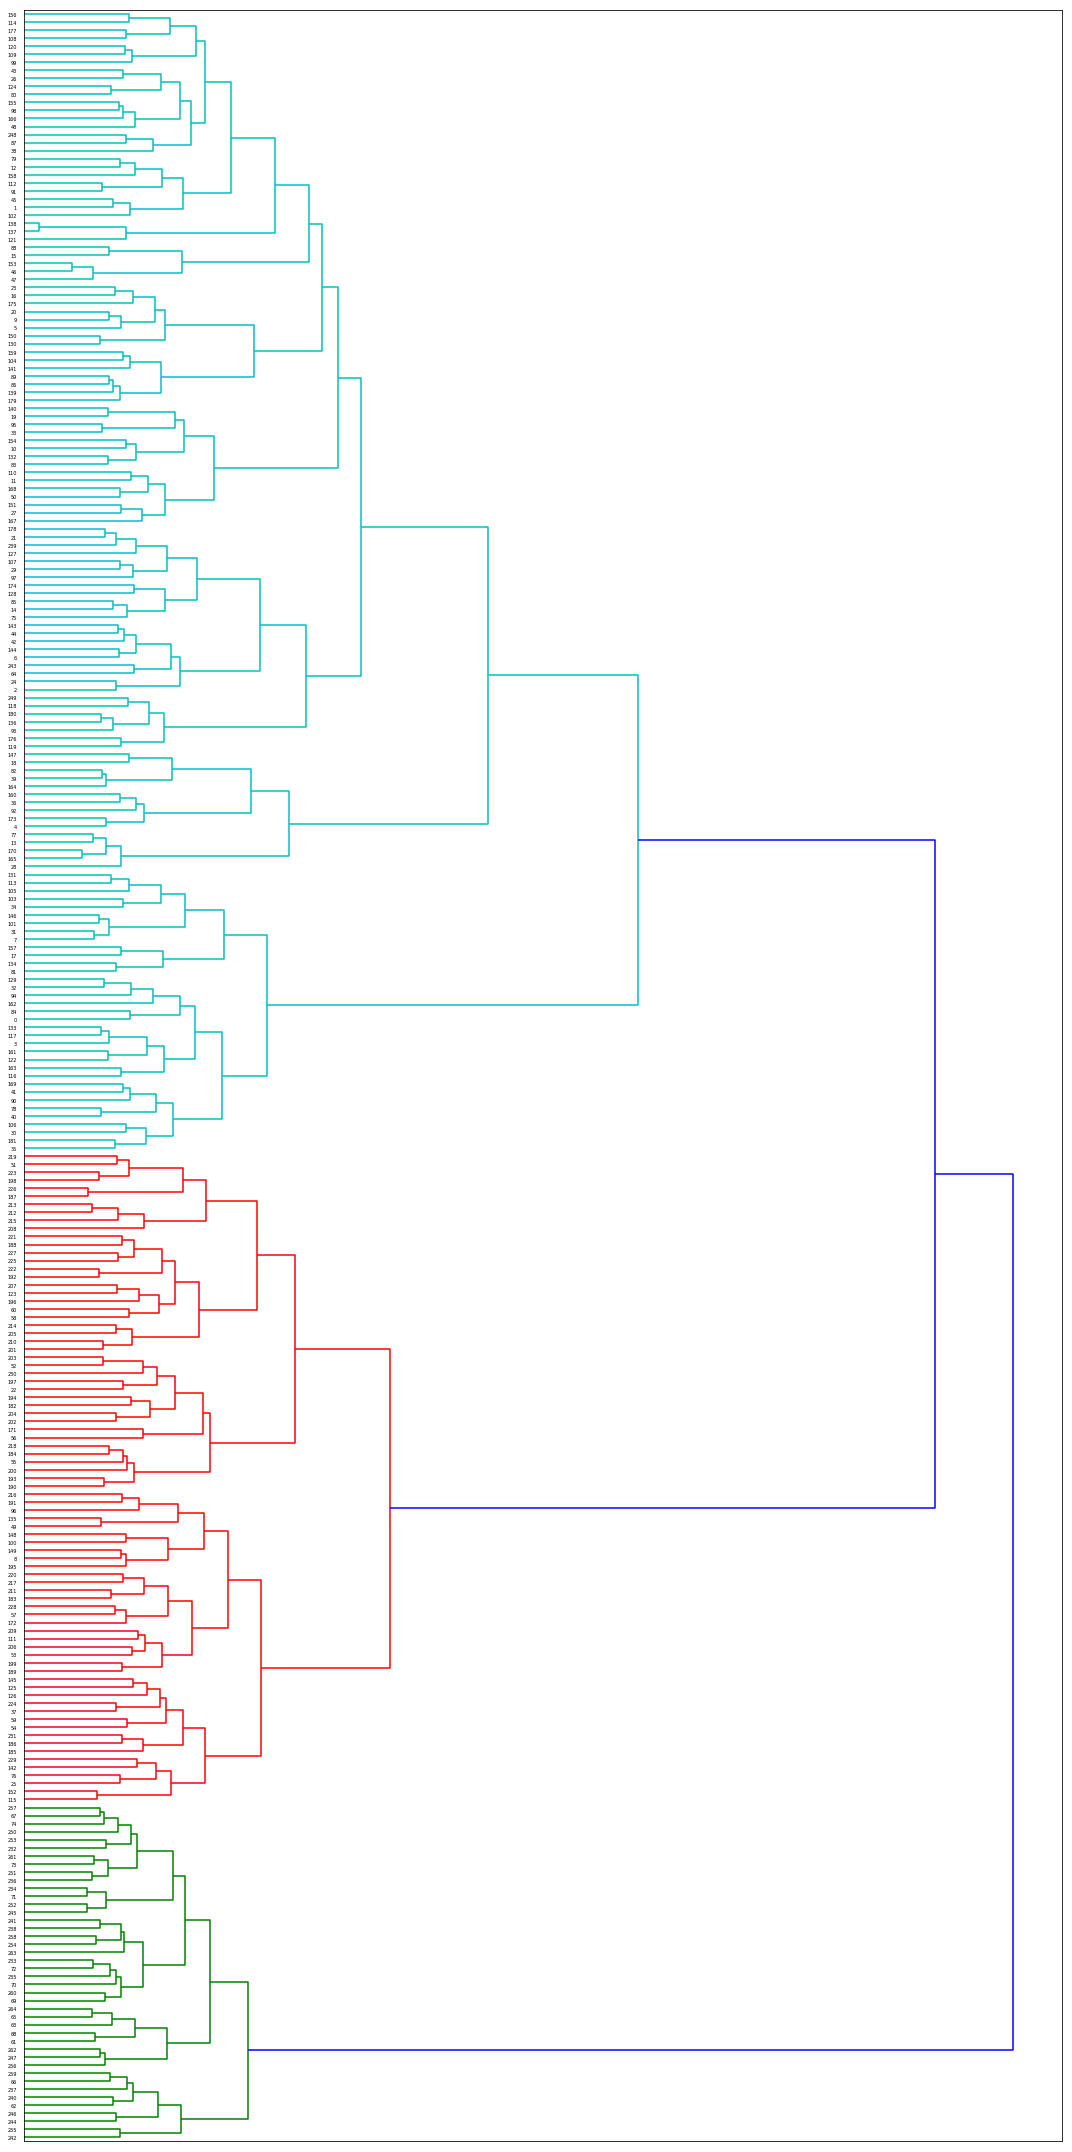

In [20]:
plot_dendrogram(vectorizer, dist)

## LDA
Here we try a new approach, Latent Dirichlet Allocation, which is destined to model topics. We can expect that result will be different.

In [21]:
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_short, strip_punctuation, stem_text

In [22]:
strip_short2 = lambda x: strip_short(x, minsize=2)
# Pipeline for preprocessing in Genism is different. For simplicity we don't use stemming here.
CUSTOM_FILTERS = [lambda x: x, remove_stopwords, strip_punctuation, strip_short2, stem_text]
tokens = df_artists[field].apply(lambda s: preprocess_string(s, CUSTOM_FILTERS))

In [23]:
dictionary = corpora.Dictionary(tokens)
doc_term_matrix = [dictionary.doc2bow(text) for text in tokens]

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# number of topics is the same as for K-Means 
num_topics = num_clusters
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, 
                num_topics=num_topics, 
                alpha=[0.0001] * num_topics, 
                eta=[0.0001] * len(dictionary),
                chunksize=2000,
                passes=4,
                random_state=100,
               )

In [25]:
lda_model.print_topics(num_words=8)

[(0,
  '0.019*"it" + 0.017*"you" + 0.012*"want" + 0.012*"like" + 0.012*"and" + 0.011*"don" + 0.009*"got" + 0.009*"yeah"'),
 (1,
  '0.030*"you" + 0.019*"love" + 0.017*"don" + 0.013*"know" + 0.013*"and" + 0.011*"let" + 0.011*"it" + 0.011*"re"'),
 (2,
  '0.029*"you" + 0.020*"babi" + 0.019*"la" + 0.016*"love" + 0.015*"it" + 0.015*"and" + 0.014*"like" + 0.014*"know"')]

In [27]:
# Visualize the topics
pd.options.display.max_colwidth = 2000
viz = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, mds='tsne')

In [28]:
pyLDAvis.enable_notebook()
viz

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
0      -632.045471 -384.325073       1        1  41.446556
2     -1209.665405  212.164124       2        1  30.020744
1     -1437.453247 -586.322510       3        1  28.532692, topic_info=     Category         Freq       Term        Total  loglift  logprob
794   Default   268.000000         la   268.000000  30.0000  30.0000
29    Default   488.000000       love   488.000000  29.0000  29.0000
107   Default   438.000000       babi   438.000000  28.0000  28.0000
60    Default  1032.000000        you  1032.000000  27.0000  27.0000
2248  Default    83.000000       gimm    83.000000  26.0000  26.0000
2831  Default    58.000000      radar    58.000000  25.0000  25.0000
959   Default    59.000000    freakin    59.000000  24.0000  24.0000
696   Default   226.000000       life   226.000000  23.0000  23.0000
112   Default   303.000000      choru   303.000000  22.0000  22.0000
86    Default   320.000000         re   320.000000  21.0000  21.0000
759   Default    37.000000         wo    37.000000  20.0000  20.0000
26    Default   303.000000        let   303.000000  19.0000  19.0000
80    Default   476.000000       know   476.000000  18.0000  18.0000
534   Default   160.000000         ya   160.000000  17.0000  17.0000
742   Default    57.000000        cry    57.000000  16.0000  16.0000
246   Default   122.000000      gonna   122.000000  15.0000  15.0000
1867  Default    35.000000    chillin    35.000000  14.0000  14.0000
63    Default   263.000000        but   263.000000  13.0000  13.0000
11    Default   557.000000        don   557.000000  12.0000  12.0000
285   Default    94.000000      break    94.000000  11.0000  11.0000
513   Default    58.000000       lose    58.000000  10.0000  10.0000
287   Default   276.000000        can   276.000000   9.0000   9.0000
269   Default   125.000000        she   125.000000   8.0000   8.0000
494   Default    89.000000       your    89.000000   7.0000   7.0000
2041  Default    54.000000      power    54.000000   6.0000   6.0000
981   Default    36.000000     beauti    36.000000   5.0000   5.0000
963   Default    22.000000        mmm    22.000000   4.0000   4.0000
302   Default    49.000000       more    49.000000   3.0000   3.0000
3485  Default    26.000000  westcoast    26.000000   2.0000   2.0000
175   Default    47.000000     forget    47.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
86     Topic3   133.438690         re   320.841461   0.3768  -4.5155
112    Topic3   128.008194      choru   303.833557   0.3897  -4.5571
313    Topic3    38.863079       burn    64.037231   0.7547  -5.7491
364    Topic3   118.062180         me   290.122742   0.3550  -4.6379
40     Topic3   131.796967         oh   338.244049   0.3116  -4.5279
95     Topic3    94.521111        the   217.298553   0.4217  -4.8603
7      Topic3   118.357803       come   301.421570   0.3193  -4.6354
80     Topic3   159.930130       know   476.757141   0.1618  -4.3344
47     Topic3    41.938358        sai    72.992310   0.7000  -5.6729
57     Topic3    85.284592        wai   205.012772   0.3770  -4.9632
287    Topic3   104.555077        can   276.828339   0.2804  -4.7594
1140   Topic3    34.975410       dead    57.103001   0.7639  -5.8545
2      Topic3   154.806503        and   556.045532  -0.0246  -4.3670
103    Topic3    67.688538       when   157.087433   0.4122  -5.1942
51     Topic3    47.284142      thing    91.035233   0.5990  -5.5530
71     Topic3    93.002632       feel   284.980927   0.1343  -4.8765
59     Topic3   105.394348       yeah   379.243073  -0.0263  -4.7514
133    Topic3    76.962875       need   218.819351   0.2092  -5.0658
94     Topic3    65.165672       tell   161.963806   0.3437  -5.2322
246    Topic3    55.522907      gonna   122.790222   0.4604  -5.3923
24     Topic3   134.218201         it   661.665344  -0.3412  -4.5097
107  

In [29]:
def LDA_clustering(num_words=3):
    
    all_topics = lda_model.get_document_topics(doc_term_matrix, per_word_topics=True)
    
    topics = lda_model.print_topics(num_words=num_words)
    clusters_lda = {}
    cluster_names = {}

    # get named clusters 
    for x in topics:
        cluster_words = ''
        for proba_with_word in x[1].split('+'):
            cluster_words += ' ' + proba_with_word.split('"')[1]
        clusters_lda[str(x[0])+cluster_words] = []
        cluster_names[x[0]] = str(x[0])+cluster_words

    counter = 0
    for doc_topics, word_topics, phi_values in all_topics:
        cluster_with_highest_proba = max(doc_topics, key = lambda item: item[1])[0]
        cluster_name = cluster_names[cluster_with_highest_proba]
        clusters_lda[cluster_name].append(counter)
        counter += 1
        
    return clusters_lda

In [30]:
clusters_lda = LDA_clustering()

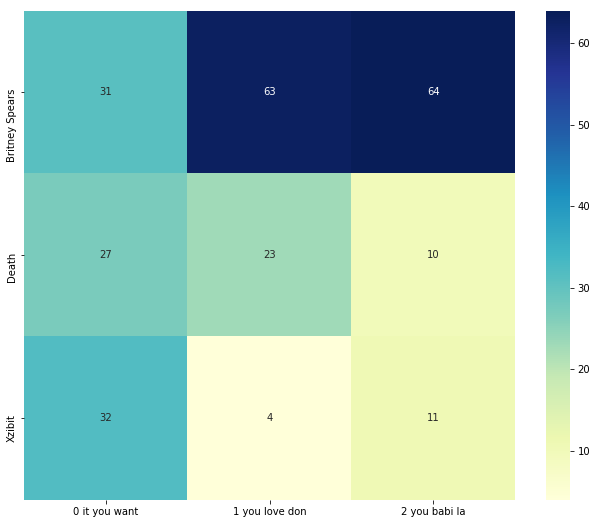

In [31]:
conf_matrix_clusters(df_artists, clusters = clusters_lda)

So as we can see LDA doesn't cluster the songs by artists, instead it found some different topics.

## Semi-supervised learning
What if we label some songs by hand and propagate the labels on the unlabeled data?  
To save time let's cluster the songs automatically (because we know the right answer) and later delete a few values in *cluster* column.

In [32]:
def structured_field_clustering(df, field):
    """
    Fill `cluster` column in dataframe `df` based on `field` column. 
    """
    assert field in df.columns, field+' is not in df columns'
    assert sum(df[field].isna()) == 0, 'There are some undefined values in df.'+field
    df_ri = df.reset_index(drop=True)
    df_ri['cluster'] = 'cluster ' + df_ri[field]
    return df_ri

In [33]:
df_artists_SSL = structured_field_clustering(df_artists, 'artist')
for i in range(len(df_artists_SSL)):
    # leave approximately 30% for training
    if np.random.random() > 0.3:
        df_artists_SSL.loc[i, 'cluster'] = None

In [34]:
def auto_fill_in(df, field):
    """
    Automatically propagate labels in `df`.
    """
    assert field in df.columns, field+' is not in df columns'
    df_ri = df.reset_index(drop=True)
    train_ind = df_ri.loc[~df_ri.cluster.isna()].index
    target_ind = df_ri.loc[df_ri.cluster.isna()].index
    assert len(train_ind) > 0, 'There is no labeled data in df'
    assert len(target_ind) > 0, 'There is no unlabeled data in df'
    train = df_ri.iloc[train_ind]
    target = df_ri.iloc[target_ind]
    
    texts = df_ri[field].apply(lambda x: x.lower().replace('\n', ''))
    vectorizer = define_vectorizer()
    X = compute_tfidf_matrix(texts.values, vectorizer)
    
    X_train = X[train_ind]
    X_target = X[target_ind]
    
    le = LabelEncoder()
    y_train = le.fit_transform(train['cluster'].values)
        
    KNN = KNeighborsClassifier(n_neighbors=1) # any n_neighbors is fine
    KNN.fit(X_train, y_train) 
    
    y_target = KNN.predict(X_target)
    y_cluster = le.inverse_transform(y_target)
    
    df_ri.loc[target_ind, 'cluster'] = y_cluster
    
    return df_ri

In [35]:
df_artists_SSL_filled = auto_fill_in(df_artists_SSL, 'text')

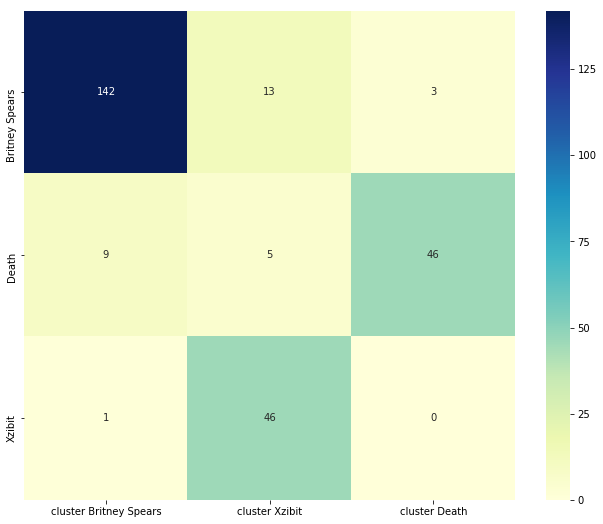

In [36]:
conf_matrix_clusters(df_artists_SSL_filled, dict_labels(df_artists_SSL_filled['cluster']))

If we want to get a better result, we can label some more data and iterate the process until we are satisfied with the quality.

In [37]:
df_artists_SSL = structured_field_clustering(df_artists, 'artist')
for i in range(len(df_artists_SSL)):
    # leave approximately 50% for training
    if np.random.random() > 0.5:
        df_artists_SSL.loc[i, 'cluster'] = None

In [38]:
df_artists_SSL_filled = auto_fill_in(df_artists_SSL, 'text')

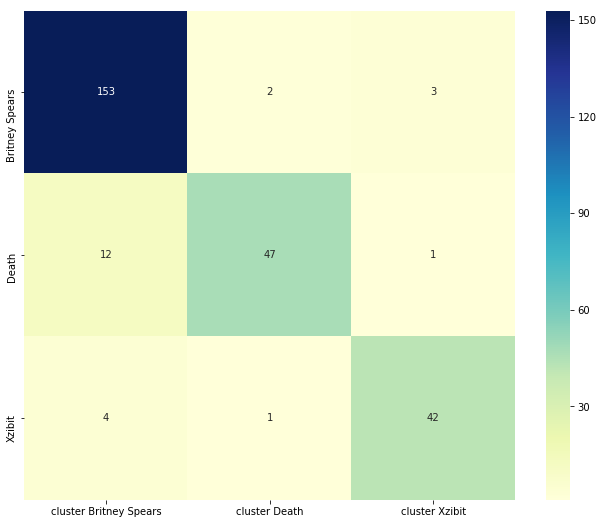

In [39]:
conf_matrix_clusters(df_artists_SSL_filled, dict_labels(df_artists_SSL_filled['cluster']))

# Install missing libraries

In [2]:
# !pip install nltk

    100% |████████████████████████████████| 3.1MB 2.4MB/s ta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/97/8a/10/d646015f33c525688e91986c4544c68019b19a473cb33d3b55
Successfully built nltk


In [14]:
# pip install gensim==3.7.3

    100% |████████████████████████████████| 24.2MB 1.1MB/s ta 0:00:01  0% |▎                               | 225kB 3.2MB/s eta 0:00:08    2% |▊                               | 573kB 3.3MB/s eta 0:00:08    6% |██                              | 1.6MB 3.6MB/s eta 0:00:07    10% |███▍                            | 2.6MB 3.4MB/s eta 0:00:07    14% |████▌                           | 3.4MB 4.0MB/s eta 0:00:06    14% |████▊                           | 3.6MB 2.9MB/s eta 0:00:08    23% |███████▌                        | 5.7MB 1.9MB/s eta 0:00:10    26% |████████▌                       | 6.4MB 2.6MB/s eta 0:00:07    28% |█████████▎                      | 7.0MB 3.8MB/s eta 0:00:05    47% |███████████████▎                | 11.6MB 3.1MB/s eta 0:00:05    48% |███████████████▋                | 11.8MB 4.2MB/s eta 0:00:03    54% |█████████████████▌              | 13.2MB 2.7MB/s eta 0:00:05    56% |██████████████████▏             | 13.7MB 3.4MB/s eta 0:00:04    57% |██████████████████▍             | 13.9M

In [9]:
# !pip install pyldavis

    100% |████████████████████████████████| 1.6MB 2.2MB/s ta 0:00:01
    100% |████████████████████████████████| 286kB 2.2MB/s ta 0:00:01
    100% |████████████████████████████████| 225kB 2.6MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 2.6MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 7.0MB/s ta 0:00:011
    100% |████████████████████████████████| 92kB 6.2MB/s ta 0:00:011
  Stored in directory: /home/jovyan/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built pyldavis future
